### Анализ имен в США с 1880 по 2010 гг.

Использовались разные библиотеки: matplotlib, seaborn, bokeh.

In [1]:
import pandas as pd
import numpy as np
import glob
import string
from math import pi

import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.palettes import viridis
from bokeh.layouts import row, column

sns.set_context("paper", font_scale=1.2)
output_notebook()

Loading BokehJS ...

In [2]:
data = pd.DataFrame()

for filename in glob.glob('data/babynames/' + '*.txt'):
    part_data = pd.read_csv(filename, header=None, names=['name', 'sex', 'number'])
    part_data['year'] = int(filename[18:22])
    data = pd.concat((data, part_data))

In [3]:
print(data.shape)
data.head()

(1690784, 4)


,name,sex,number,year
0,Jennifer,F,57096,1982
1,Jessica,F,45425,1982
2,Amanda,F,34209,1982
3,Sarah,F,28470,1982
4,Melissa,F,25851,1982


#### 1. Сгруппируйте данные по полу и году и визуализируйте общую динамику рождаемости обоих полов.

seaborn

In [4]:
df = (data.groupby(by=['sex', 'year'])['number'].sum()/10**5).unstack(level=0)

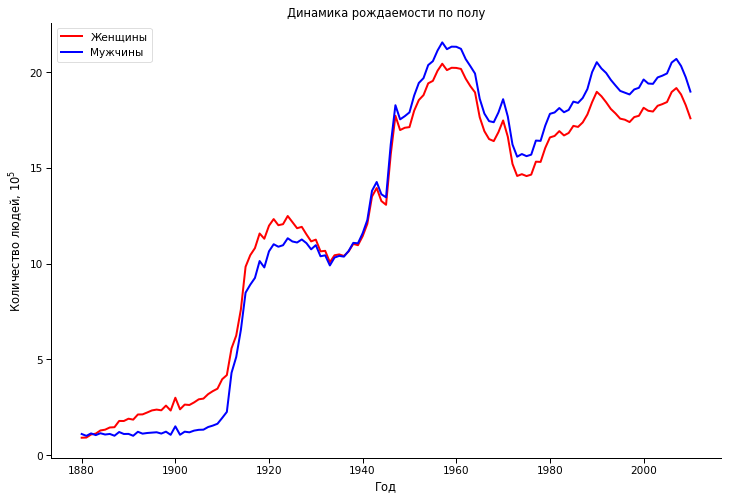

In [5]:
f, ax = plt.subplots(figsize=(12, 8))
g = sns.lineplot(data=df, ax=ax, dashes=False, linewidth=2, palette=['red', 'blue'])
sns.despine()
g.legend(('Женщины', 'Мужчины'));
g.set(xlabel='Год', ylabel='Количество людей, $10^5$')
g.set_title('Динамика рождаемости по полу');

#### 2. Найдите самые популярные имена за всю историю

matplotlib

In [6]:
top_number = 20
df_female = data.groupby(by=['sex', 'name'])['number'].sum()['F'].sort_values(ascending=False)[:top_number]
df_male = data.groupby(by=['sex', 'name'])['number'].sum()['M'].sort_values(ascending=False)[:top_number]
df_female = (df_female/10**6).reset_index()
df_male = (df_male/10**6).reset_index()

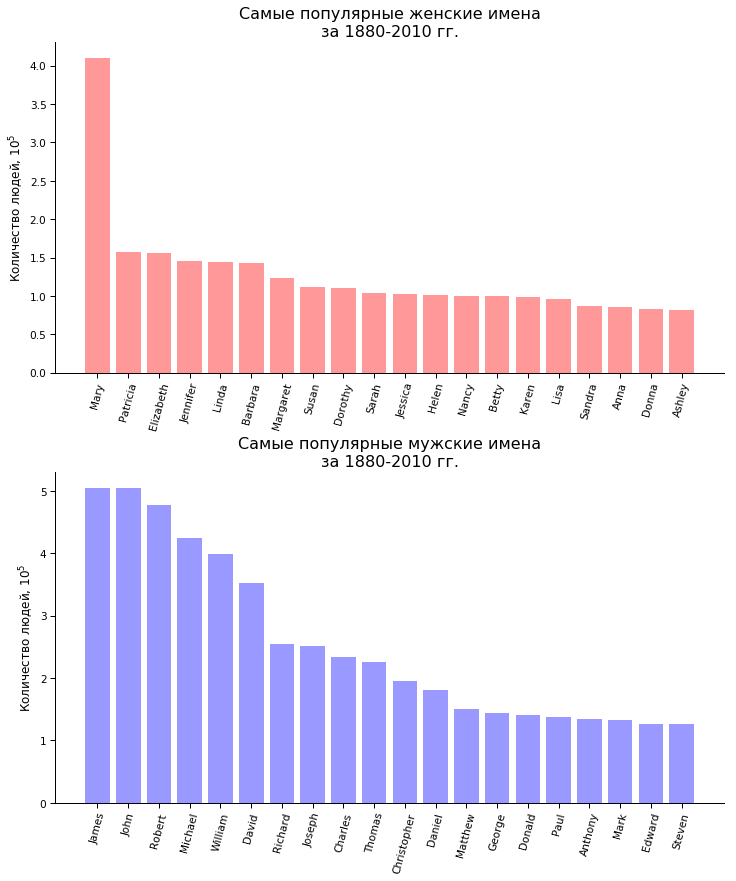

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 14))
fig.subplots_adjust(hspace=0.3)

colors = ['red', 'blue']
title_template = 'Самые популярные {} имена\nза 1880-2010 гг.'
titles = [title_template.format('женские'), title_template.format('мужские')]

for df, ax, color, title in zip([df_female, df_male], axes, colors, titles):
    ax.bar(df.name, df.number, alpha=0.4, color=color)
    ax.set_xticks(np.arange(20))
    ax.set_xticklabels(df.name, rotation=75)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Количество людей, $10^5$', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

plt.show()

#### 3. Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за все время

bokeh

In [8]:
# Вычисление популярных имен для каждого временного промежутка
top_names = pd.DataFrame(columns=['time_start', 'time_end', 'female_name', 'male_name'])

year_boundary = np.arange(1880, 2011, 13)
top_names['time_start'] = year_boundary[:-1]
top_names['time_end'] = year_boundary[1:]

for i in range(len(top_names)):
    time_start = top_names.loc[i, 'time_start']
    time_end = top_names.loc[i, 'time_end']
    
    grouped_names = data[(data.year >= time_start) & (data.year <= time_end)].\
                        groupby(by=['sex', 'name'])['number'].sum()
    
    top_names.loc[i, 'female_name'] = grouped_names['F'].sort_values(ascending=False).index[0]
    top_names.loc[i, 'male_name'] = grouped_names['M'].sort_values(ascending=False).index[0]
    
top_names

,time_start,time_end,female_name,male_name
0,1880,1893,Mary,John
1,1893,1906,Mary,John
2,1906,1919,Mary,John
3,1919,1932,Mary,Robert
4,1932,1945,Mary,Robert
5,1945,1958,Mary,James
6,1958,1971,Lisa,Michael
7,1971,1984,Jennifer,Michael
8,1984,1997,Jessica,Michael
9,1997,2010,Emily,Jacob


In [9]:
# данные для визуализации
female_names = top_names['female_name'].unique()
male_names = top_names['male_name'].unique()

df_female = data[data['name'].isin(female_names)].groupby(['name', 'year'])['number'].sum().reset_index()
df_male = data[data['name'].isin(male_names)].groupby(['name', 'year'])['number'].sum().reset_index()

df_female['number'] = df_female['number']/10**4
df_male['number'] = df_male['number']/10**4

In [10]:
figures = []

title_template = 'Динамика популярных {} имен из разных временных промежутков'
titles = [title_template.format('женских'), title_template.format('мужских')]

for df, title in zip([df_female, df_male], titles):
    names = df['name'].unique()
    source = ColumnDataSource(df)
    fig = figure(plot_width=750, plot_height=500)
    fig.title.text = title
    fig.xaxis.axis_label = 'Год'
    fig.yaxis.axis_label = 'Количество людей, 10^4'
    fig.add_tools(HoverTool(tooltips=[
        ('year', '$x{int}'), ('number', '$y')
    ]))

    for i, name in zip(np.arange(5), names):
        view = CDSView(source=source, filters=[GroupFilter(column_name='name', group=name)])
        fig.line(x='year', y='number', source=source, view=view,\
                  color=viridis(5)[i], line_width=2, legend=name)

        fig.legend.location = "top_left"
        fig.legend.click_policy="hide"
        
    figures.append(fig)
    
show(column(figures[0], figures[1]))

#### 4. Для каждого года рассчитайте сколько имен покрывают 50% людей, визуализируйте (мы увидим разнообразие имен за каждый год)

matplotlib

In [11]:
data_percent = data.groupby(by=['year', 'sex']).apply(lambda x: x['number']/x['number'].sum()).\
                reset_index(name='percent')
data_percent_grouped = data_percent.groupby(by=['year', 'sex']).\
                apply(lambda x: x.sort_values(by='percent', ascending=False)['percent'].\
                                 cumsum().values.searchsorted(0.5))
df = data_percent_grouped.unstack('sex').reset_index()

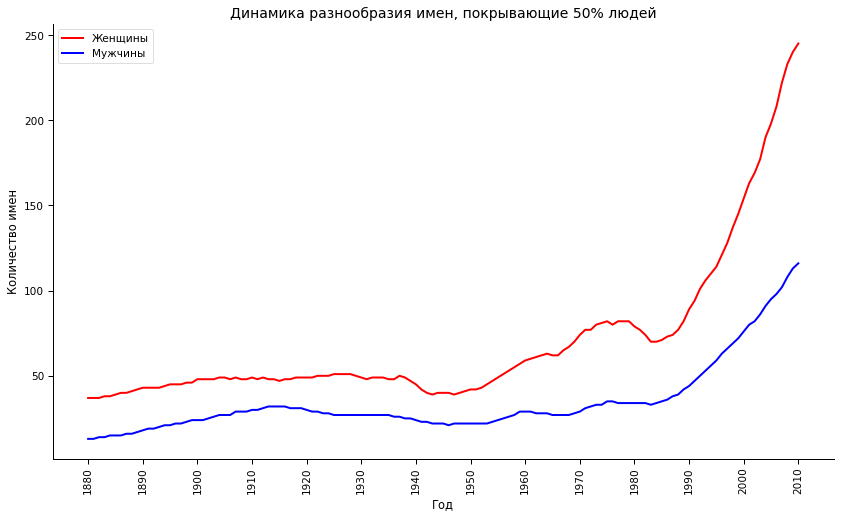

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(df['year'], df['F'], color='red', linewidth=2, label='Женщины')
ax.plot(df['year'], df['M'], color='blue', linewidth=2, label='Мужчины')

ax.set(xlabel='Год', ylabel='Количество имен')
ax.set_title('Динамика разнообразия имен, покрывающие 50% людей', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(df['year'].values[::10], rotation='vertical')
plt.legend()
plt.show()

#### 5. Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени

seaborn

In [13]:
years = [1890, 1930, 1970, 2010]

In [14]:
data['first_letter'] = data['name'].apply(lambda name: name[0])
data['last_letter'] = data['name'].apply(lambda name: name[-1].upper())

In [15]:
df_first = data[data['year'].isin(years)].groupby(['year', 'first_letter'])['number'].sum().reset_index()
df_last = data[data['year'].isin(years)].groupby(['year', 'last_letter'])['number'].sum().reset_index()

df_first.columns = df_last.columns = ['year', 'letter', 'number']

df_first['number'] = df_first['number']/10**5
df_last['number'] = df_last['number']/10**5

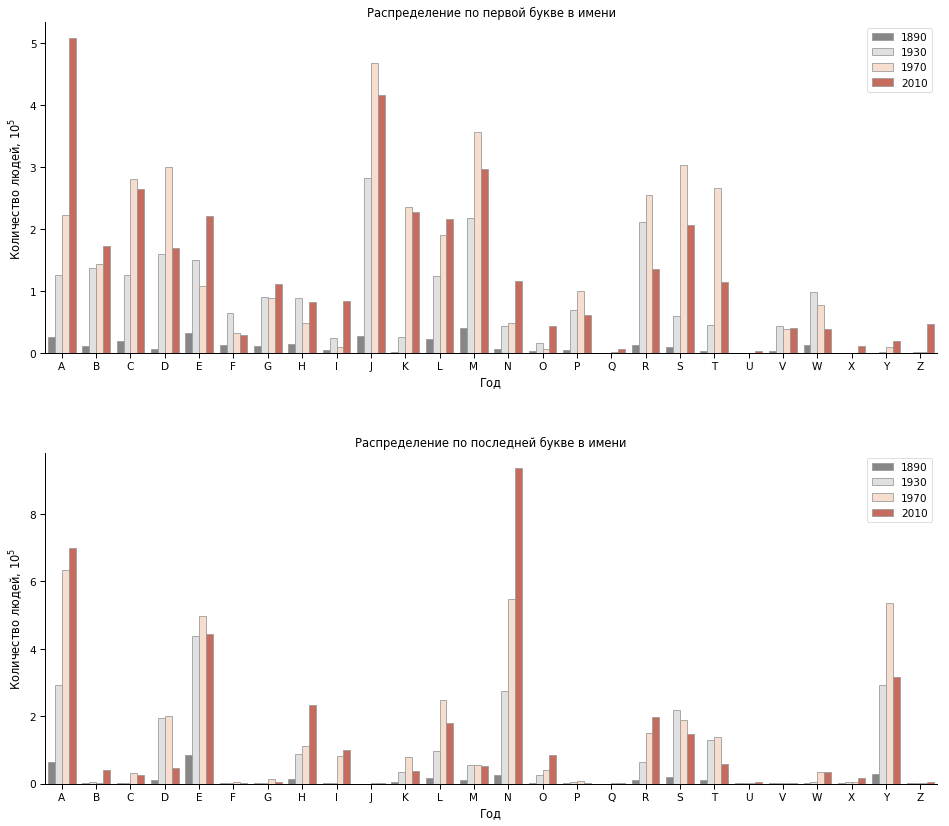

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 14))
fig.subplots_adjust(hspace=0.3)
sns.despine()

titles = ['Распределение по первой букве в имени', \
          'Распределение по последней букве в имени']

with sns.color_palette('RdGy_r', 4):
    for df, ax, title in zip([df_first, df_last], axes, titles):
        g = sns.barplot(x='letter', y='number', hue='year', data=df, \
                        order=list(string.ascii_uppercase), ax=ax, edgecolor=".6")
        g.set_title(title)
        g.set(xlabel='Год', ylabel='Количество людей, $10^5$')
        g.legend(loc='upper right')

#### 6. Составьте список из нескольких известных людей (президенты, певцы, актеры, киногерои) и оцените их влияние на динамику имен, постройте наглядную визуализацию

seaborn

На графиках с визуализацией пунктиром отмечен год, в который начался рост популярности личности или ее пик. 

Самое значительное влияние из рассмотренных ниже оказал Шон Коннери: видно два скачка, скорее всего они связаны с выходом фильмов про Джеймса Бонда. Имя Элвис не было слишком популярным всегда, но все же в 1956 году наблюдается большой рост практически с нуля. С американскими грабителями Бонни и Клайдом не все однозначно: на графиках видно, что женское имя было какое-то время известным после 1940 г., а вот мужское наоборот стало терять популярность. Имя американского президента Франклина Рузвельта в первые годы работы на посту было ходовым среди родителей. Не очень повезло Мэрилин Монро: ее именем с каждым годом девочек называли все меньше. 

In [17]:
famous_people = {'Marilyn': 1950, 
                 'Elvis': 1956,
                 'Bonnie': 1932, 
                 'Clyde': 1932, 
                 'Sean': 1962, 
                 'Franklin': 1933}

In [18]:
df = data[data.name.isin(famous_people.keys())].\
        groupby(by=['name','year'])['number'].sum().reset_index()

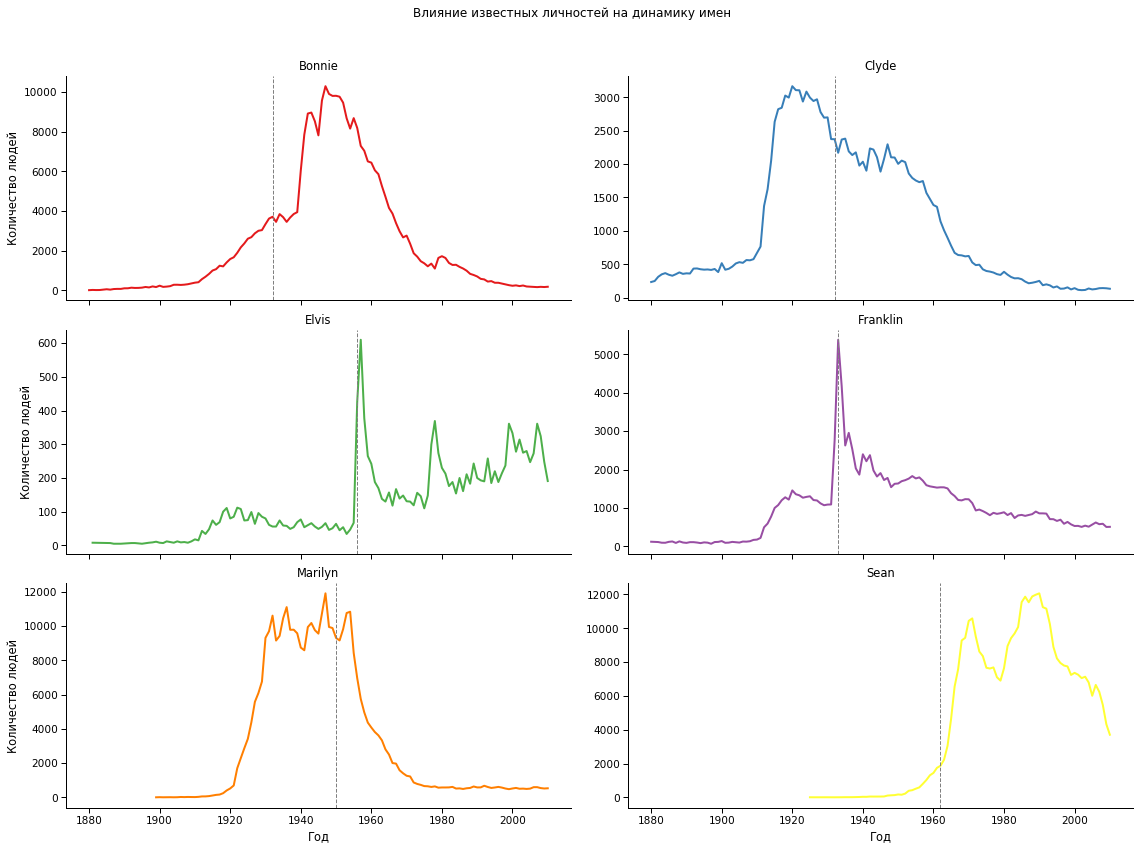

In [19]:
grid = sns.FacetGrid(df, col='name', hue='name', col_wrap=2, \
                     height=4, aspect=2, palette="Set1", sharey=False)
grid.map(sns.lineplot, 'year', 'number', lw=2)

grid.fig.suptitle('Влияние известных личностей на динамику имен')
grid.fig.subplots_adjust(top=0.9)

grid.set_titles("{col_name}")
grid.set_axis_labels(x_var="Год", y_var="Количество людей")

for ax in grid.axes:
    date = famous_people[ax.get_title()]
    ax.axvline(date, linestyle='dashed', linewidth=1, color='gray')